In [1]:
from kmcluster.core.kmc_minimum import kmc
from kmcluster.core.transition_conditions import rfkmc
from kmcluster.core.intialize import random_init, boltz
from kmcluster.core.data import sparse_to_mat, test_dataset_1, test_dataset_2


# Pt4H3_all, Pt4H3_relE = test_dataset_2()
Pt_H1_all, H1_E = test_dataset_2()
energies_mat = sparse_to_mat(Pt_H1_all)

T_kelvin = 100
temp_boltz = T_kelvin * 8.617 * 10 ** (-5)
rfkmc_obj = rfkmc(k_b_t=temp_boltz, energy_mat=energies_mat)
time_stop = 0.0001
init_boltz = boltz(energies=H1_E, T=temp_boltz, size=10000)
init_random = random_init(10000, energies_mat.shape[0])

/home/santiagovargas/anaconda3/envs/allegro/lib/python3.9/site-packages/brisk/funcs.py:99: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dot(x, y):
/home/santiagovargas/anaconda3/envs/allegro/lib/python3.9/site-packages/brisk/funcs.py:174: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def interp(x, xp, fp):
/home/santiagovargas/anaconda3/envs/allegro/lib/pyt

In [2]:
# print mat with 2 decimal places
import numpy as np

np.set_printoptions(formatter={"float": lambda x: "{0:0.7f}".format(x)})

In [3]:
# initialize kmc object
kmc_boltz = kmc(
    time_stop=time_stop,
    energies=energies_mat,
    draw_crit=rfkmc_obj,
    initialization=init_random,
    checkpoint=True,
    sample_frequency=1000,
    ckptprefix="Pt4H2_g_{}_".format(T_kelvin),
    state_dict_file=None,
    checkpoint_dir="./checkpoints/",  # change this to organize runs
    batch_size=1000,
)

# run calcs
# can either run to a certain number of steps or until a certain time
# n_steps=-1 means run until time_stop is reached
kmc_boltz.run(n_steps=-1)
# kmc_boltz.run(n_steps=100)
trajectories = kmc_boltz.trajectories

results mat shape:  (26, 1001)
initialization populations
{0: 391, 1: 380, 2: 368, 3: 382, 4: 401, 5: 362, 6: 406, 7: 349, 8: 401, 9: 372, 10: 377, 11: 373, 12: 413, 13: 393, 14: 394, 15: 392, 16: 371, 17: 394, 18: 375, 19: 416, 20: 401, 21: 372, 22: 401, 23: 341, 24: 380, 25: 395}
done initializing....
starting run
Calc Done!
hit checkpoint 1/10
saving checkpoint at step 1000
done with kmc run to stop time 0.0001
this took 1000 steps
sum of results at each probe time: [10000.0000000 10000.0000000 10000.0000000 ... 10000.0000000 10000.0000000
 10000.0000000]
Lowest time at final step 1000: 5.82627e-02
mean time at final step: 8.93801e+08



In [4]:
kmc_boltz.plot_top_n_states_stacked(
    n_show=-1,
    max_time=0.0001,
    title="State Distribution, {}K".format(T_kelvin),
    xlabel="Time (s)",
    ylabel="Population Proportion",
    save=True,
    show=True,
    save_name="./plots/Pt4H2_stacked_{}_top{}.png".format(T_kelvin, -1),
)

/home/santiagovargas/anaconda3/envs/allegro/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



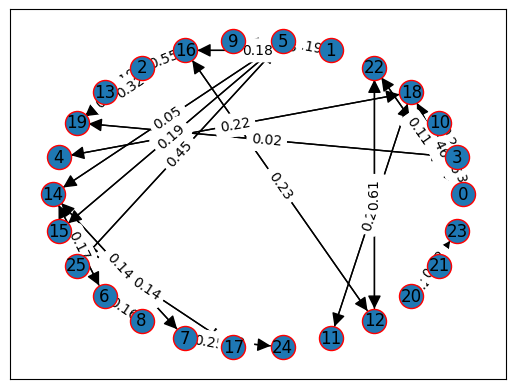

In [5]:
import networkx as nx
import matplotlib.pyplot as plt


def graph_trajectories_static(
    energies,
    ret_pos=False,
    pos=None,
    ax=None,
    save=False,
    save_name="test.png",
):
    """
    given a list of trajectories, plot the state of at time_to_plot as a graph
    """
    # make matrix whether there is a rate connecting two states
    G = nx.DiGraph()

    for i in range(len(energies)):
        for j in range(len(energies)):
            if energies[i][j] > 0:
                """G.add_weighted_edges_from(
                    [(i, j, energies[i][j])], label=round(energies[i][j], 2)
                )"""
                G.add_edge(
                    i, j, label=round(energies[i][j], 2), weight=1 / energies[i][j]
                )

    if pos is None:
        pos = nx.spring_layout(G)
        pos = nx.kamada_kawai_layout(G)
        pos = nx.spectral_layout(G)
        pos = nx.circular_layout(G)

    if ax != None:
        nodes = nx.draw_networkx_nodes(
            G,
            pos,
            cmap=plt.cm.YlOrRd,
            ax=ax,
        )
        # Set edge color to red
        nodes.set_edgecolor("r")
        nx.draw_networkx_edges(G, pos, arrowstyle="-|>", arrowsize=20, ax=ax)
        # Uncomment this if you want your labels
        nx.draw_networkx_labels(G, pos, ax=ax)
        # edge labels
        nx.draw_networkx_edge_labels(
            G, pos, edge_labels=nx.get_edge_attributes(G, "label"), ax=ax
        )
    else:
        nodes = nx.draw_networkx_nodes(
            G,
            pos,
            cmap=plt.cm.YlOrRd,
        )
        # Set edge color to red
        nodes.set_edgecolor("r")
        nx.draw_networkx_edges(
            G,
            pos,
            arrowstyle="-|>",
            arrowsize=20,
        )
        # Uncomment this if you want your labels
        nx.draw_networkx_labels(G, pos, ax=ax)
        # edge labels
        nx.draw_networkx_edge_labels(
            G,
            pos,
            edge_labels=nx.get_edge_attributes(G, "label"),
        )

    plt.show()
    if ret_pos:
        return pos
    return G


G = graph_trajectories_static(energies_mat)

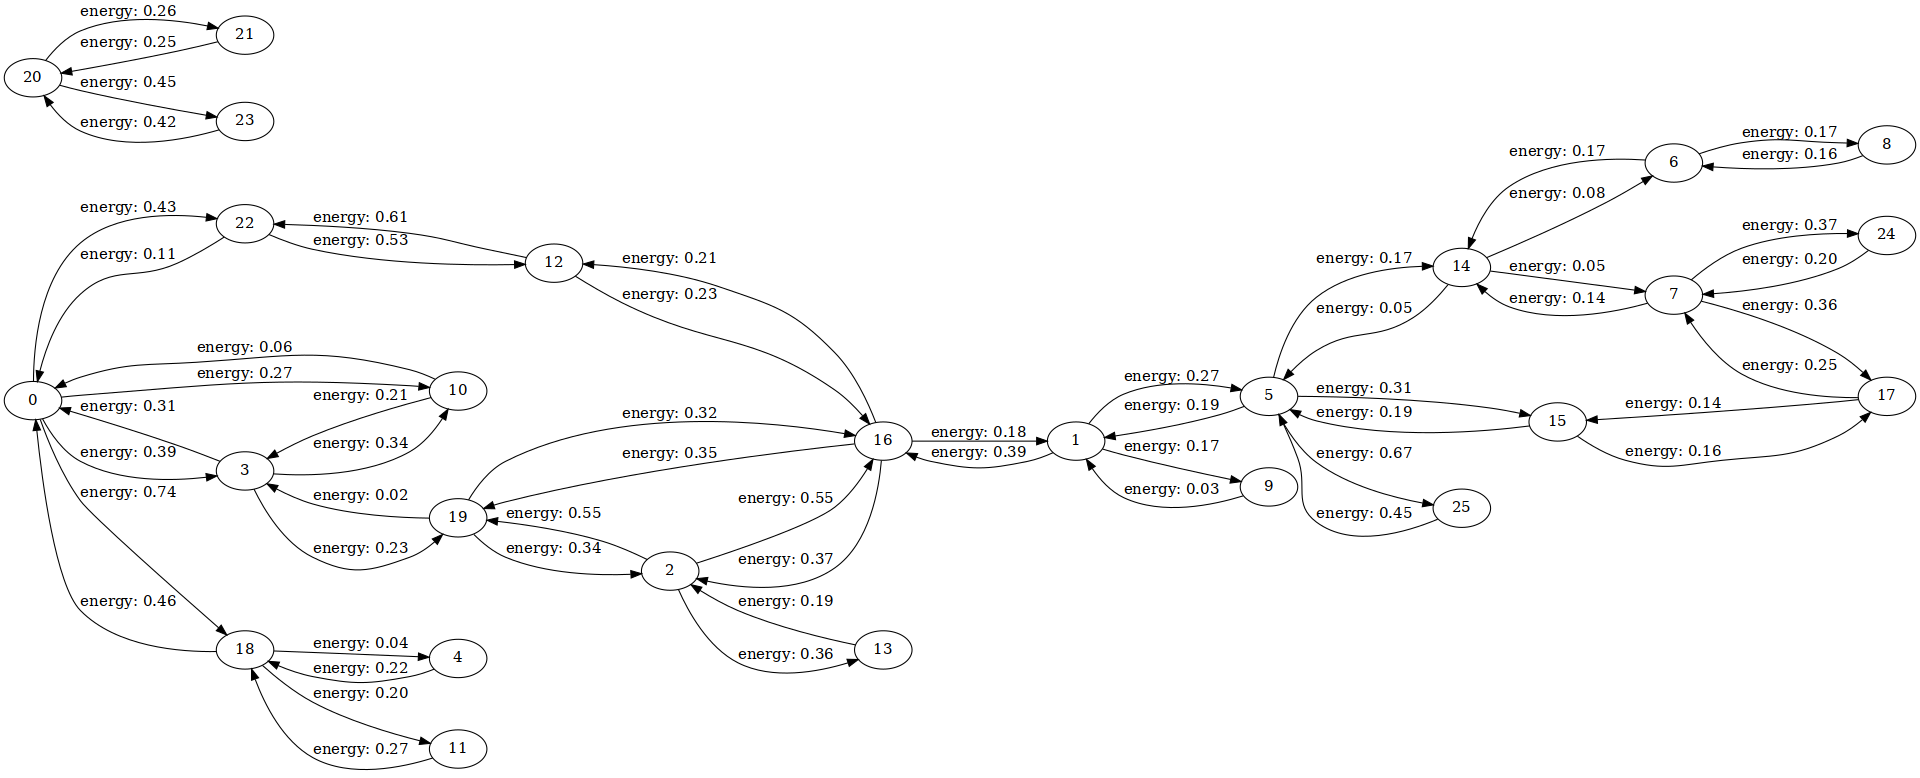

In [6]:
import pygraphviz as pgv
from IPython.display import Image, Markdown, display


def visualise(graph, hide=False, clusters=None, circular=False):
    layout = "neato" if circular else "dot"
    oneblock = True if circular else False
    G = pgv.AGraph(
        strict=False,
        directed=graph.is_directed(),
        rankdir="LR",
        newrank="True",
        layout=layout,
        oneblock=oneblock,
    )

    targetGraph = {}

    if clusters is not None:
        for label, cluster in clusters:
            name = "cluster_%s" % label.lower().replace(" ", "_")
            subgraph = G.add_subgraph(name=name, label=label, labelloc="b", rank="same")
            for node in cluster:
                targetGraph[node] = subgraph
    else:
        for n in graph.nodes():
            targetGraph[n] = G

    for n, data in graph.nodes(data=True):
        label = "%s " % n
        for attribute, value in data.items():
            if not hide:
                label += "\n%s = " % attribute
            label += "\n%s," % value
        if len(label) > 1:
            label = label[0:-1]
        targetGraph[n].add_node(n, label=label)
    for u, v, data in graph.edges(data=True):
        dir = "forward" if graph.is_directed() else "none"
        label = ""
        for attribute, value in data.items():
            if attribute == "label":
                label += "energy: {:.3f}".format(value)
            # if not hide:
            #    label +=  " %s = " % attribute
            # label += "%s," % value
        if len(label) > 1:
            label = label[0:-1]
        G.add_edge(u, v, dir=dir, label=label)
        G.layout(prog="dot")
    display(Image(G.draw(format="png", args="-Gsize=20 -Gratio=0.4")))
    return


visualise(G, circular=False)

initialization populations
{0: 388, 1: 376, 2: 382, 3: 370, 4: 388, 5: 396, 6: 428, 7: 361, 8: 410, 9: 371, 10: 361, 11: 410, 12: 428, 13: 366, 14: 362, 15: 414, 16: 385, 17: 386, 18: 357, 19: 346, 20: 376, 21: 388, 22: 398, 23: 368, 24: 388, 25: 397}


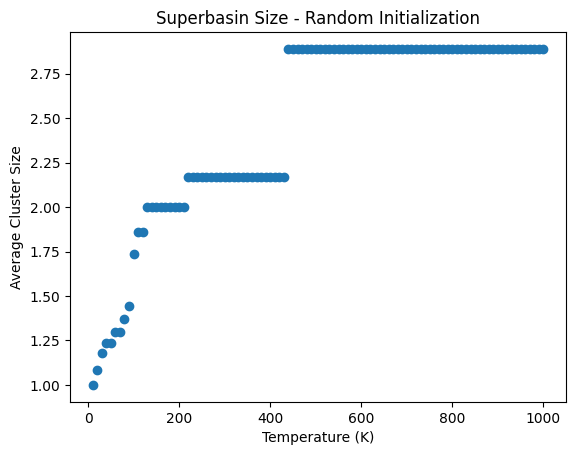

Cluster 0
State 0 w energy: 0.000
State 10 w energy: 0.212
State 11 w energy: 0.218
State 22 w energy: 0.322

Cluster 1
State 1 w energy: 0.053
State 5 w energy: 0.132
State 9 w energy: 0.196
State 16 w energy: 0.262

Cluster 2
State 2 w energy: 0.082
State 13 w energy: 0.248
State 25 w energy: 0.348

Cluster 3
State 3 w energy: 0.082
State 19 w energy: 0.293

Cluster 4
State 4 w energy: 0.109
State 18 w energy: 0.284

Cluster 5
State 6 w energy: 0.159
State 8 w energy: 0.170
State 12 w energy: 0.240

Cluster 6
State 7 w energy: 0.162
State 14 w energy: 0.248
State 24 w energy: 0.336

Cluster 7
State 15 w energy: 0.250
State 17 w energy: 0.268

Cluster 8
State 20 w energy: 0.300
State 21 w energy: 0.308
State 23 w energy: 0.332



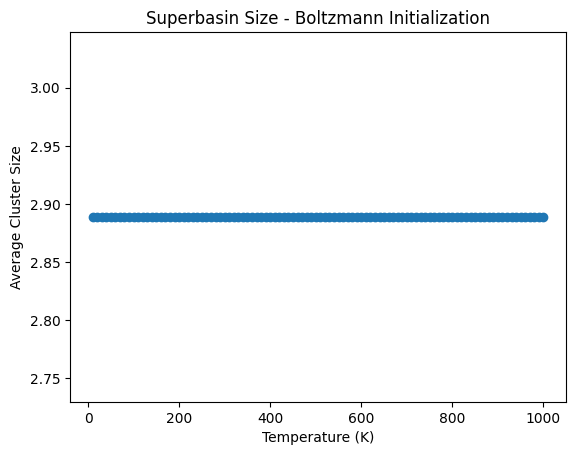

Cluster 0
State 0 w energy: 0.000
State 10 w energy: 0.212
State 22 w energy: 0.322

Cluster 1
State 1 w energy: 0.053
State 5 w energy: 0.132
State 9 w energy: 0.196
State 12 w energy: 0.240
State 16 w energy: 0.262

Cluster 2
State 2 w energy: 0.082
State 13 w energy: 0.248

Cluster 3
State 3 w energy: 0.082
State 19 w energy: 0.293

Cluster 4
State 4 w energy: 0.109
State 18 w energy: 0.284

Cluster 5
State 6 w energy: 0.159
State 8 w energy: 0.170
State 11 w energy: 0.218
State 25 w energy: 0.348

Cluster 6
State 7 w energy: 0.162
State 14 w energy: 0.248
State 24 w energy: 0.336

Cluster 7
State 15 w energy: 0.250
State 17 w energy: 0.268

Cluster 8
State 20 w energy: 0.300
State 21 w energy: 0.308
State 23 w energy: 0.332



In [8]:
from kmcluster.core.data import nice_print_clusters, energy_to_rates
from sklearn.cluster import AffinityPropagation
import statistics as st
import matplotlib.pyplot as plt

init_boltz = boltz(energies=H1_E, T=temp_boltz, size=10000)
init_random = random_init(10000, energies_mat.shape[0])


def temp_sweep_and_plot(
    energies_mat,
    min_temp=10,
    max_temp=1000,
    num_temps=100,
    pref=None,
    title=None,
    ret_ap=False,
):
    list_clusters = []
    list_temps = []
    top_cluster_list = []
    av_cluster_size = []

    for temp in np.linspace(min_temp, max_temp, num_temps):
        rate_mat = energy_to_rates(energies_mat, temp, scale=1)
        ap = AffinityPropagation(
            affinity="precomputed", max_iter=10000, preference=pref
        ).fit(rate_mat)
        n_clusters = ap.cluster_centers_indices_
        n_top_cluster = st.mode(ap.labels_)
        top_cluster = len(np.where(ap.labels_ == n_top_cluster)[0])
        list_clusters.append(len(n_clusters))
        list_temps.append(temp)
        top_cluster_list.append(top_cluster)
        av_cluster_size.append(len(energies_mat) / len(n_clusters))
        # print(n_clusters)
        # print(n_clu)

    plt.scatter(x=list_temps, y=av_cluster_size)
    # plt.scatter(x=list_temps, y=list_clusters)
    # plt.scatter(x=list_temps, y=top_cluster_list)
    plt.xlabel("Temperature (K)")
    plt.ylabel("Average Cluster Size")
    if title is not None:
        plt.title(title)
    else:
        plt.title("Number of Clusters vs Temperature")
    plt.show()
    # print(ap.labels_)
    # compute the number of indices in top cluster
    # get the most common index
    # np.mode(ap.labels_)
    n_top_cluster = st.mode(ap.labels_)
    if ret_ap:
        return ap


ap_rand = temp_sweep_and_plot(
    energies_mat,
    pref=init_random.get_init_populations(),
    title="Superbasin Size - Random Initialization",
    ret_ap=True,
)
nice_print_clusters(ap_rand, H1_E)  # this prints the clusters @ highest temp

ap_boltz = temp_sweep_and_plot(
    energies_mat,
    pref=init_boltz.get_init_populations(),
    title="Superbasin Size - Boltzmann Initialization",
    ret_ap=True,
)
nice_print_clusters(ap_boltz, H1_E)

In [9]:
# This function will also run affinity prop at a given temp and give you back the clusters


def affinity_at_temp(
    energies_mat,
    energy_list,
    temp=100,
    pref=None,
):
    rate_mat = energy_to_rates(energies_mat, temp, scale=1)
    ap = AffinityPropagation(
        affinity="precomputed", max_iter=10000, preference=pref
    ).fit(rate_mat)
    # n_clusters = ap.cluster_centers_indices_
    # n_top_cluster = st.mode(ap.labels_)
    # top_cluster = len(np.where(ap.labels_ == n_top_cluster)[0])
    nice_print_clusters(ap, energy_list)


affinity_at_temp(energies_mat, energy_list=H1_E, temp=100)

Cluster 0
State 0 w energy: 0.000
State 10 w energy: 0.212
State 22 w energy: 0.322

Cluster 1
State 1 w energy: 0.053
State 5 w energy: 0.132
State 9 w energy: 0.196
State 11 w energy: 0.218
State 16 w energy: 0.262

Cluster 2
State 2 w energy: 0.082
State 13 w energy: 0.248

Cluster 3
State 3 w energy: 0.082
State 19 w energy: 0.293

Cluster 4
State 4 w energy: 0.109
State 12 w energy: 0.240
State 18 w energy: 0.284
State 25 w energy: 0.348

Cluster 5
State 6 w energy: 0.159
State 8 w energy: 0.170

Cluster 6
State 7 w energy: 0.162
State 14 w energy: 0.248
State 24 w energy: 0.336

Cluster 7
State 15 w energy: 0.250
State 17 w energy: 0.268

Cluster 8
State 20 w energy: 0.300
State 21 w energy: 0.308
State 23 w energy: 0.332

